Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

# Imports

In [1]:
import pandas as pd
import numpy as np

import pandas_profiling

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from category_encoders import OneHotEncoder

# Read in data

In [3]:
from functions import wrangle

In [4]:
path = r"C:\Users\allan\OneDrive\Desktop\data_sets\28524_45582_compressed_AnimeList.csv\AnimeList.csv"
df = pd.read_csv(path)

# Clean data

In [5]:
clean = wrangle(df)

# EDA

In [6]:
clean.profile_report()

# Split X and y

In [7]:
y = clean['rank'].copy()
X = clean.drop('rank',axis=1).copy()

# TTS

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

# Model(ForestRegressor)

In [9]:
forest = make_pipeline(OneHotEncoder(use_cat_names=True),RandomForestRegressor(random_state=42,n_jobs=-1))
forest.fit(X_train,y_train);

In [10]:
baseline = [y_train.mean()]

print(f"Forest train : {forest.score(X_train,y_train)}")
print(f"Forest test: {forest.score(X_test,y_test)}")
print()
print(f"Base MAE: {mean_absolute_error(y_train,baseline*len(y_train))}\n")
print(f"Train MAE: {mean_absolute_error(y_train,forest.predict(X_train))}")
print(f"Test MAE: {mean_absolute_error(y_test,forest.predict(X_test))}")

Forest train : 0.908852481804514
Forest test: 0.5951523956976764

Base MAE: 3210.093119097792

Train MAE: 810.9215869109889
Test MAE: 1769.313299686446


# Hyper params

In [11]:
hyper_forest = make_pipeline(OneHotEncoder(use_cat_names=True),
                             RandomForestRegressor(random_state=42,min_samples_split=2,
                                                   n_estimators=200,n_jobs=-1,min_samples_leaf=1,
                                                  max_features='sqrt',max_depth=30))

hyper_forest.fit(X_train,y_train);

In [12]:
print(f"Forest train : {hyper_forest.score(X_train,y_train)}")
print(f"Forest test: {hyper_forest.score(X_test,y_test)}")
print()
print(f"Base MAE: {mean_absolute_error(y_train,baseline*len(y_train))}")
print()
print(f"Train MAE: {mean_absolute_error(y_train,hyper_forest.predict(X_train))}")
print(f"Test MAE: {mean_absolute_error(y_test,hyper_forest.predict(X_test))}")

Forest train : 0.9117492723452564
Forest test: 0.6218471780380627

Base MAE: 3210.093119097792

Train MAE: 801.4757147242016
Test MAE: 1727.8876028077505


Yeah this is what i though was weird for hyper param tuning. It tries all combinations and return whatever gave the best score, doesn't that just mean more overfitting? I feel like it should fit on taining the tune on validation right?

# Random Params

In [13]:
rand_param = {'randomforestregressor__n_estimators': [100,200,300],
             'randomforestregressor__max_features':['auto','sqrt','log2'],
             'randomforestregressor__max_depth':[10,20,30,40,50,None],
             'randomforestregressor__min_samples_split':[2,5,10,15,20],
             'randomforestregressor__min_samples_leaf':[1,2,5,10,15]}

In [15]:
test = make_pipeline(OneHotEncoder(use_cat_names=True),
                     RandomForestRegressor(n_jobs=-1))

rand_grid = RandomizedSearchCV(estimator=test,param_distributions=rand_param,
                               n_iter=500,verbose=2,random_state=42,n_jobs=-1)

In [22]:
#rand_grid.fit(X_train,y_train);

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  5.8min
C:\Users\allan\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                     

In [23]:
#print(rand_grid.best_params_)

{'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__max_depth': 20}


# Tuned model

In [24]:
tuned = make_pipeline(OneHotEncoder(use_cat_names=True),RandomForestRegressor(random_state=42,n_jobs=-1,
                                                                              n_estimators=300,min_samples_split=2,
                                                                              min_samples_leaf=1,max_features='log2',
                                                                              max_depth=20))
tuned.fit(X_train,y_train);

In [25]:
baseline = [y_train.mean()]

print(f"Forest train : {tuned.score(X_train,y_train)}")
print(f"Forest test: {tuned.score(X_test,y_test)}")
print()
print(f"Base MAE: {mean_absolute_error(y_train,baseline*len(y_train))}\n")
print(f"Train MAE: {mean_absolute_error(y_train,tuned.predict(X_train))}")
print(f"Test MAE: {mean_absolute_error(y_test,tuned.predict(X_test))}")

Forest train : 0.8668499882949577
Forest test: 0.6343397615822601

Base MAE: 3210.093119097792

Train MAE: 1025.2414647098533
Test MAE: 1728.92070627533


# Graph Feature Importances

In [20]:
import matplotlib.pyplot as plt

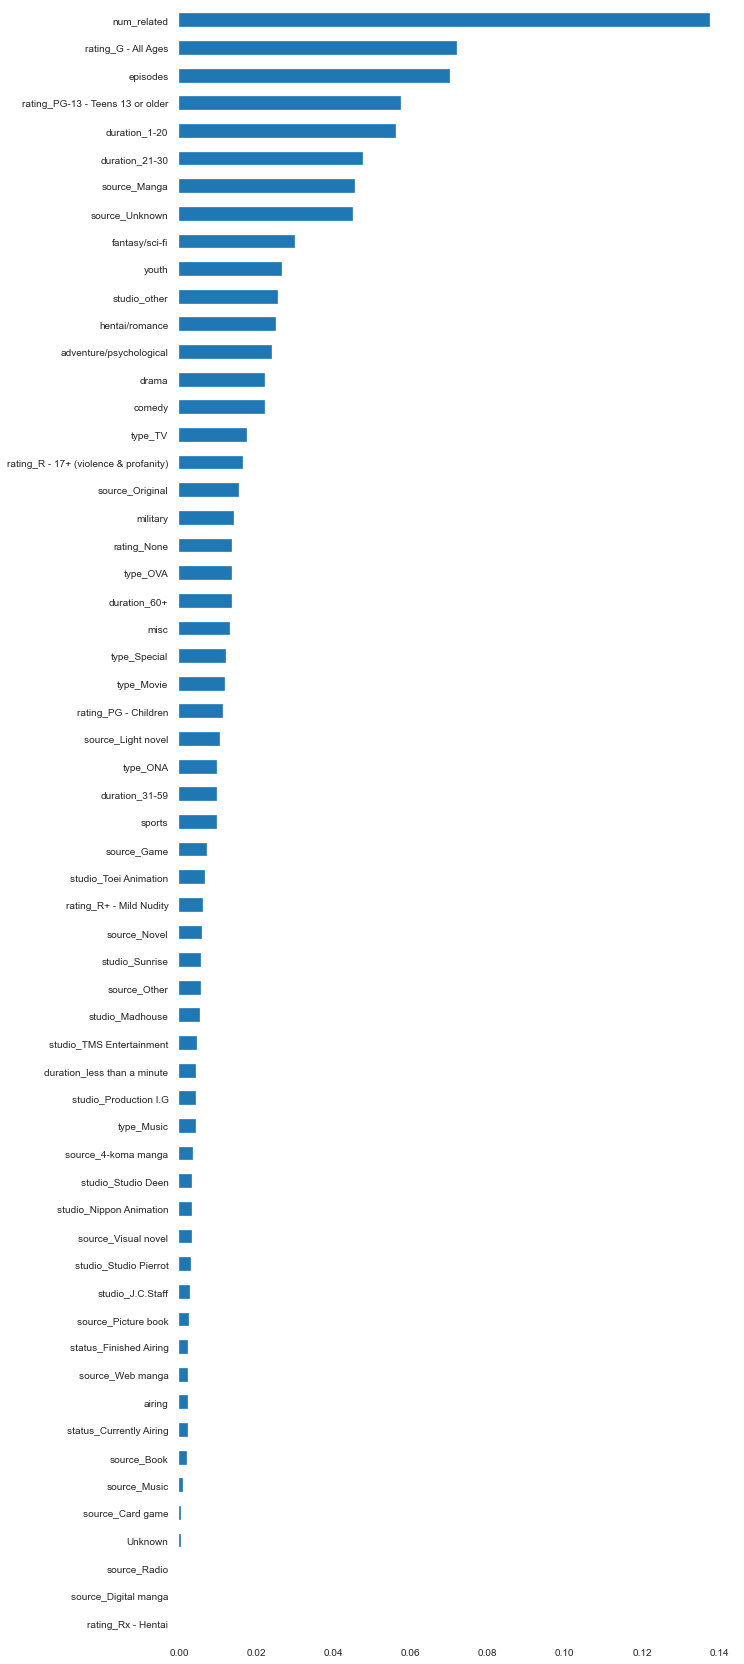

In [26]:
encoder = tuned.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(tuned.named_steps['randomforestregressor'].feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();